# Visualize output results for Figure 2 -- task activation X FC change gradient

## Takuya Ito
#### 05/14/2020

In [23]:
import numpy as np
from utils.bootstrap_corr import *
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
plt.style.use("ggplot")
sns.set_style('whitegrid')
plt.rcParams["font.family"] = "Arial"
import nibabel as nib
import pandas as pd
import h5py
from importlib import reload
import os
from brainsmash.mapgen.base import Base
from brainsmash.mapgen.stats import pearsonr, pairwise_r

## Set-up parameters

In [29]:
## General parameters/variables 
nParcels = 360

glasserfile2 = '../resultdata/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

color1, color2 = sns.color_palette(palette='pastel',n_colors=2)

# Import network partition
networkdef = np.loadtxt('../resultdata/network_partition.txt')
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()
 
associationnets = ['con','dan','lan','fpn','dmn','pmulti','none1','none2']
sensorimotornets = ['vis1','vis2','smn','aud']

roi_id = np.zeros((nParcels,))
tmp = {}
netcount = 0
for network in networkmappings:
    net = np.where(networkdef==networkmappings[network])[0]
    for roi in net:
        if network in associationnets:
            tmp[roi] = color1 #'r'
            roi_id[roi] = -1
        else:
            tmp[roi] = color2 #'b'
            roi_id[roi] = 1
    netcount += 1
    
roiColorsByNetwork = []
for roi in range(len(networkdef)):
    roiColorsByNetwork.append(tmp[roi])

/Users/tito/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


# Load in result data


#### Load in task activity and connectivity data

In [34]:
resultdir = '../resultdata/'
#
activity = np.loadtxt(resultdir + '/activity/activity_canonicalHRF.csv',delimiter=',')
t_act = np.mean(activity,axis=1)
subj_activity = np.loadtxt(resultdir + '/activity/activity_canonicalHRF_allSubjs.csv',delimiter=',')

connectivity = np.loadtxt(resultdir + '/connectivity/conn_taskVrest_gbc_FIR.csv', delimiter=',')

nsubjs = subj_activity.shape[1]

#### Load in Margulies data (principal gradient) and parcellate

In [26]:
#######################################################################################################
#### Load gradient data
# RH
gradient_rh = np.squeeze(nib.load('../../data/results/margulies2016/hcp.tmp.rh.dscalar.nii').get_data())
# Remove all the '0s' in the array
nonzero_ind = np.where(gradient_rh!=0)[0]
gradient_rh = gradient_rh[nonzero_ind].copy()
# LH
gradient_lh = np.squeeze(nib.load('../../data/results/margulies2016/hcp.tmp.lh.dscalar.nii').get_data())
# Remove all the '0s' in the array
nonzero_ind = np.where(gradient_lh!=0)[0]
gradient_lh = gradient_lh[nonzero_ind].copy()
# Glasser atlas is orgnized R->L hemispheres
gradient = np.hstack((gradient_lh,gradient_rh))
#######################################################################################################

gradient_parcellated = np.zeros((nParcels,))
for roi in range(nParcels):
    roi_ind = np.where(glasser2==roi+1)[0]
    gradient_parcellated[roi] = np.mean(gradient[roi_ind])


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/Users/tito/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/Users/tito/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if __name__ == '__main__':


# Activity X Connectivity data

Activity change
Activity difference: -2.5558969699350556
Ttest_relResult(statistic=-29.57910810544595, pvalue=5.4129545053806106e-70)
FC change
FC difference: 0.024654704895751008
Ttest_relResult(statistic=18.90636224912383, pvalue=3.8153339482002466e-44)


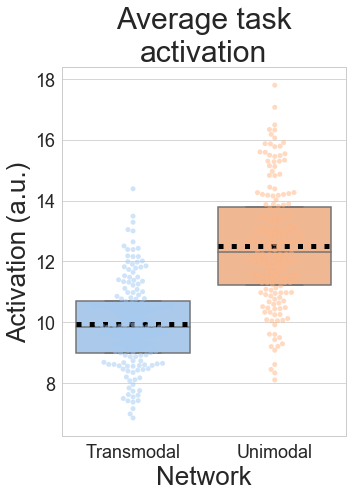

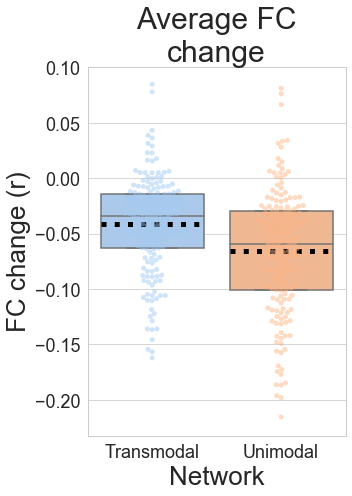

In [27]:
## Activity decodability
sensorimotor_association = np.zeros((2,nsubjs))

for net in associationnets:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    sensorimotor_association[0,:] = sensorimotor_association[0,:] + np.nanmean(subj_activity[net_ind,:],axis=0)
sensorimotor_association[0,:] = sensorimotor_association[0,:]/len(associationnets)

for net in sensorimotornets:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    sensorimotor_association[1,:] = sensorimotor_association[1,:] + np.nanmean(subj_activity[net_ind,:],axis=0)
sensorimotor_association[1,:] = sensorimotor_association[1,:]/len(sensorimotornets)

plt.figure(figsize=(5,7))
sns.boxplot(data=[sensorimotor_association[0,:],
                  sensorimotor_association[1,:]],
            palette=sns.color_palette(palette='pastel',n_colors=2),
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(data=[sensorimotor_association[0,:],
                  sensorimotor_association[1,:]],
            palette=sns.color_palette(palette='pastel',n_colors=2),
            alpha=0.5)
plt.title('Average task\nactivation',fontsize=30,fontname='Arial')
plt.ylabel('Activation (a.u.)',fontsize=26)
plt.xlabel('Network',fontsize=26)
plt.xticks(np.arange(2),['Transmodal','Unimodal'],rotation=0,fontname='Arial',fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
# plt.savefig('Fig2_TransmodalVUnimodal_ActivityChange_Set2.pdf')
print('Activity change')
print('Activity difference:', np.mean(sensorimotor_association[0,:])-np.mean(sensorimotor_association[1,:]))
print(stats.ttest_rel(sensorimotor_association[0,:],sensorimotor_association[1,:]))


##Connectivity decodability
sensorimotor_association = np.zeros((2,nsubjs))

for net in associationnets:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    sensorimotor_association[0,:] = sensorimotor_association[0,:] + np.nanmean(connectivity[net_ind,:],axis=0)
sensorimotor_association[0,:] = sensorimotor_association[0,:]/len(associationnets)

for net in sensorimotornets:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    sensorimotor_association[1,:] = sensorimotor_association[1,:] + np.nanmean(connectivity[net_ind,:],axis=0)
sensorimotor_association[1,:] = sensorimotor_association[1,:]/len(sensorimotornets)

plt.figure(figsize=(5,7))
sns.boxplot(data=[sensorimotor_association[0,:],
                  sensorimotor_association[1,:]],
            palette=sns.color_palette(palette='pastel',n_colors=2),
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(data=[sensorimotor_association[0,:],
                  sensorimotor_association[1,:]],
            palette=sns.color_palette(palette='pastel',n_colors=2),
            alpha=0.5)
plt.title('Average FC\nchange',fontsize=30,fontname='Arial')
plt.ylabel('FC change (r)',fontsize=26)
plt.xlabel('Network',fontsize=26)
plt.xticks(np.arange(2),['Transmodal','Unimodal'],rotation=0,fontname='Arial',fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
# plt.savefig('Fig2_TransmodalVUnimodal_FCChange_Set2.pdf')
print('FC change')
print('FC difference:', np.mean(sensorimotor_association[0,:])-np.mean(sensorimotor_association[1,:]))
print(stats.ttest_rel(sensorimotor_association[0,:],sensorimotor_association[1,:]))

## Run correlation analysis (group-level and within-subject) comparing activity x connectivity decodability

#### Group-level correlation

Spearman True: -0.26346731070455787 | CI = ( -0.3613657826179832 , -0.15670545471474706 )
Pearson True: -0.23834714238083232 | CI = ( -0.32277277728983395 , -0.14230697536032968 )


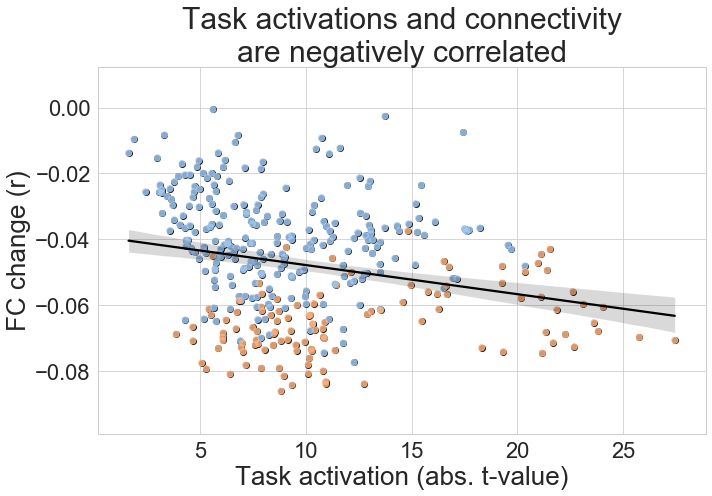

In [30]:
r, lower_ci, upper_ci = bootstrap_corr(t_act,np.mean(connectivity,axis=1),corr_type='spearman')
print('Spearman True:', r, '| CI = (', lower_ci, ',', upper_ci,')')
#
r, lower_ci, upper_ci = bootstrap_corr(t_act,np.mean(connectivity,axis=1),corr_type='pearson')
print('Pearson True:', r, '| CI = (', lower_ci, ',', upper_ci,')')

plt.figure(figsize=(10,7))
sns.regplot(t_act,np.mean(connectivity,axis=1),color='k',fit_reg=False)
sns.regplot(t_act,np.mean(connectivity,axis=1),color='k',scatter_kws={'color':roiColorsByNetwork})
plt.ylabel('FC change (r)',fontsize=26)
plt.xlabel('Task activation (abs. t-value)',fontsize=26)
plt.title('Task activations and connectivity\nare negatively correlated',fontsize=30)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
# plt.savefig('.Fig2_ActivityXConnectivity_Univariate.pdf')

# Correlate activity/connectivity changes with Margulies' principal gradient

Gradient X Task activations
Spearman True: 0.31065234556851007 | Lower bound: 0.21960377515244317 | Upper bound: 0.4093742155059241
Pearson True: 0.3424521131067117 | Lower bound: 0.24242255971908042 | Upper bound: 0.43148301980365167

Gradient X FC Change
Spearman True: -0.57719658330697 | Lower bound: -0.632759136884277 | Upper bound: -0.517274408853333
Pearson True: -0.5467915886528356 | Lower bound: -0.6043921723151595 | Upper bound: -0.4816347021712588


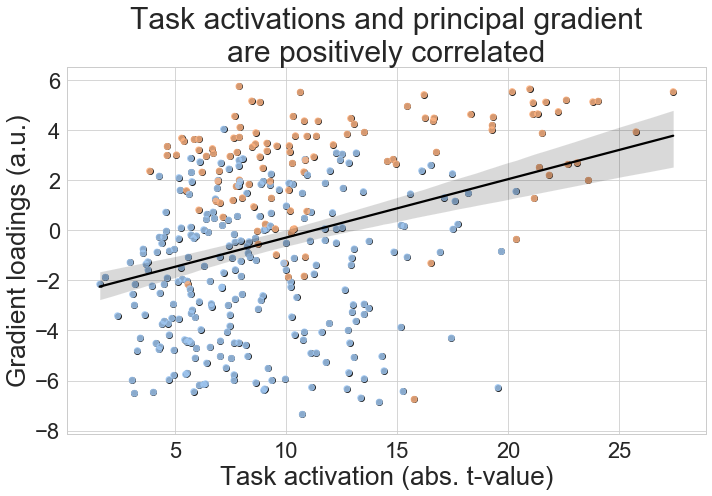

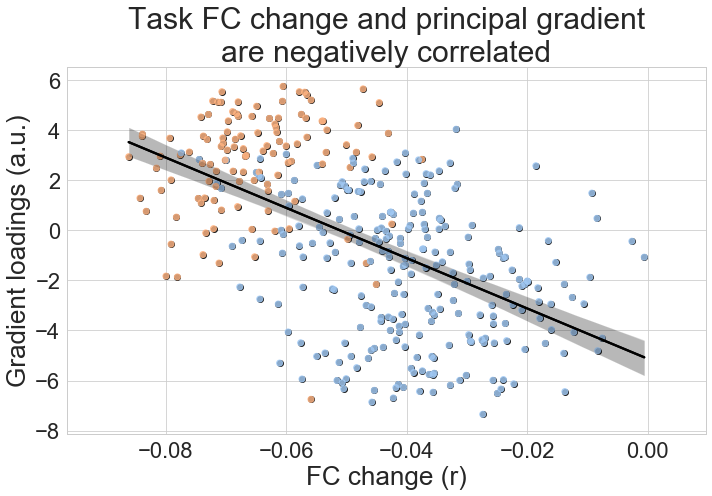

In [31]:
print('Gradient X Task activations')
r, lower_ci, upper_ci = bootstrap_corr(t_act,gradient_parcellated,corr_type='spearman')
print('Spearman True:', r, '| Lower bound:', lower_ci, '| Upper bound:', upper_ci)
#
r, lower_ci, upper_ci = bootstrap_corr(t_act,gradient_parcellated,corr_type='pearson')
print('Pearson True:', r, '| Lower bound:', lower_ci, '| Upper bound:', upper_ci)

plt.figure(figsize=(10,7))
sns.regplot(t_act,gradient_parcellated,color='k',fit_reg=False)
sns.regplot(t_act,gradient_parcellated,color='k',scatter_kws={'color':roiColorsByNetwork})
plt.ylabel('Gradient loadings (a.u.)',fontsize=26)
plt.xlabel('Task activation (abs. t-value)',fontsize=26)
plt.title('Task activations and principal gradient\nare positively correlated',fontsize=30)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
# plt.savefig('Fig2_GradientXActivity.pdf')


print('\nGradient X FC Change')
r, lower_ci, upper_ci = bootstrap_corr(np.mean(connectivity,axis=1),gradient_parcellated,corr_type='spearman')
print('Spearman True:', r, '| Lower bound:', lower_ci, '| Upper bound:', upper_ci)
#
r, lower_ci, upper_ci = bootstrap_corr(np.mean(connectivity,axis=1),gradient_parcellated,corr_type='pearson')
print('Pearson True:', r, '| Lower bound:', lower_ci, '| Upper bound:', upper_ci)

plt.figure(figsize=(10,7))
sns.regplot(np.mean(connectivity,axis=1),gradient_parcellated,color='k')
sns.regplot(np.mean(connectivity,axis=1),gradient_parcellated,color='k',scatter_kws={'color':roiColorsByNetwork})
plt.ylabel('Gradient loadings (a.u.)',fontsize=26)
plt.xlabel('FC change (r)',fontsize=26)
plt.title('Task FC change and principal gradient\nare negatively correlated',fontsize=30)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
# plt.savefig('Fig2_GradientXConnectivity.pdf')

# Create surface maps

#### Map task activation and connectivity changes to surface 

In [32]:
# roidat = np.zeros((glasser2.shape[0],2)) 

# tmp_con = np.mean(connectivity,axis=1)
# tmp_act = t_act

# print('FC: Min =', np.min(np.mean(connectivity,axis=1)), '| Max =', np.max(np.mean(connectivity,axis=1)))
# print('Act: Min =', np.min(t_act), '| Max =', np.max(t_act))

# for roi in range(nParcels):
#     roi_ind = np.where(glasser2==roi+1)[0]
    
#     roidat[roi_ind,0] = tmp_con[roi]
#     roidat[roi_ind,1] = tmp_act[roi]
    
# # Compute effect size baseline (information content)
# outdir = '../resultdata/'
# filename = 'ActivityXConn_UnivariateChange_v2'
# np.savetxt(outdir + filename + '.csv', roidat,fmt='%s')
# wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + filename + '.dscalar.nii -reset-scalars'
# os.system(wb_command)



#### Map Margulies principal gradient (parcellated)

In [33]:
# #######################################################################################################
# # Remap parcellated data on the cortical surface
# parcel2surf = np.zeros((glasser2.shape[0],1)) # fc diff, t, p, q

# for roi in range(nParcels):
#     roi_ind = np.where(glasser2==roi+1)[0]
#     parcel2surf[roi_ind,0] = np.mean(gradient_parcellated[roi])
    
# #######################################################################################################
# # Compute effect size baseline (information content)
# outdir = '../../data/results/'
# filename = 'MarguliesGradientParcellated'
# np.savetxt(outdir + filename + '.csv', parcel2surf,fmt='%s')
# wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + filename + '.dscalar.nii -reset-scalars'
# os.system(wb_command)